# Adjacent Hospital info

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')
#warnings.resetwarnings()
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Static data
counties, counties_date = load_counties()

In [3]:
deaths_df = get_cum_deaths_dataframe(n_days=30, onset_threshold=1, ma_width=7, time_series=True)
days = [d for d in deaths_df.columns if d[:4] == 'day_']

In [5]:
deaths_df.columns

Index(['FIPS', 'day_01', 'day_02', 'day_03', 'day_04', 'day_05', 'day_06',
       'day_07', 'day_08', 'day_09', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'day_29', 'day_30', 'onset', 'Beds', 'HospCt', 'OD_baseline',
       'OD_at_onset', 'OD_2wk_before_onset', 'OD_2wk_after_onset',
       'Rural-urban_Continuum Code_2013',
       'Density per square mile of land area - Population',
       'Percent of adults with less than a high school diploma 2014-18',
       'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus',
       'POP_ESTIMATE_2018', 'onset_relative'],
      dtype='object')

In [6]:
# County adjacency edge list
with open('../data/processed/county_adjacency_edge_dict.pkl', 'rb') as f:
    county_adj = pickle.load(f)

In [208]:
def get_neighboring_var(df, adj, fip, target_var):
    if fip not in adj:
        return np.nan
    neighbors = adj[fip]
    return df[df['FIPS'].isin(neighbors)][target_var]

In [18]:
deaths_df['neighboring_hospitals'] = deaths_df.apply(
    lambda x: get_neighboring_var(deaths_df, county_adj, x['FIPS'], 'HospCt').sum(), axis=1
)

In [29]:
deaths_df['neighboring_deaths'] = deaths_df.apply(
    lambda x: get_neighboring_var(deaths_df, county_adj, x['FIPS'], days[-1]).sum(), axis=1
)

In [210]:
deaths_df['neighboring_pop'] = deaths_df.apply(
    lambda x: get_neighboring_var(deaths_df, county_adj, x['FIPS'], 'POP_ESTIMATE_2018').sum(), axis=1
)

(array([ 15.,  44., 145., 210., 216., 154.,  87.,  35.,   4.,   5.]),
 array([0.        , 0.53518581, 1.07037163, 1.60555744, 2.14074325,
        2.67592907, 3.21111488, 3.74630069, 4.28148651, 4.81667232,
        5.35185813]),
 <a list of 10 Patch objects>)

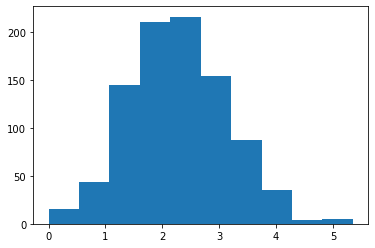

In [25]:
plt.hist(np.log(deaths_df['neighboring_hospitals'] + 1))

In [198]:
deaths_df['hospital_diff'] = deaths_df['HospCt'] / (deaths_df['neighboring_hospitals'] + 1)
deaths_df['cum_death_diff'] = deaths_df[days[-1]] / deaths_df['neighboring_deaths']
deaths_df['cum_death_diff_per_capita'] = deaths_df[days[-1]] / deaths_df.POP_ESTIMATE_2018 / ((deaths_df['neighboring_deaths'] +1)/ deaths_df['neighboring_pop'])

[None, None]

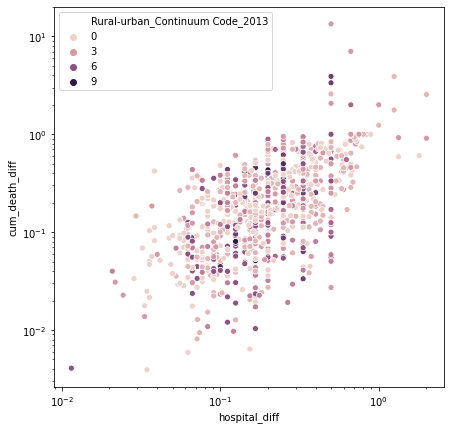

In [199]:
fig, ax = plt.subplots(figsize=(7,7))
g = sns.scatterplot(
    x = 'hospital_diff',
    y = 'cum_death_diff',
    hue = 'Rural-urban_Continuum Code_2013',
    data = deaths_df
)
g.set(xscale="log", yscale="log")

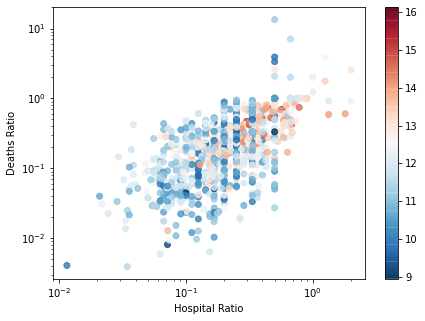

spearman r : SpearmanrResult(correlation=0.6867839466638825, pvalue=1.2293359589381033e-128)


In [200]:
fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(
    deaths_df.hospital_diff,
    deaths_df.cum_death_diff,
    alpha = .8,
    c = np.log(deaths_df.POP_ESTIMATE_2018),
    cmap = 'RdBu_r'
)
ax.set_xlabel('Hospital Ratio')
ax.set_ylabel('Deaths Ratio')
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(sc)
plt.show()
print(f'spearman r : {spearmanr(deaths_df.hospital_diff, deaths_df.cum_death_diff)}')

In [184]:
test_stat = spearmanr(deaths_df.hospital_diff, deaths_df.cum_death_diff)[0]
null_dist = []
n_iter = 100 - 1
pval = 1 / (n_iter + 1)
keys = list(county_adj.keys())
for _ in range(n_iter):
    vals = list(county_adj.values()).copy()
    np.random.shuffle(vals)
    null_dict = {key: list(set(val) - set([key])) for key, val in zip(keys, vals)}
    neighboring_hospitals = deaths_df.apply(
        lambda x: get_neighboring_var(deaths_df, null_dict, x['FIPS'], 'HospCt'), axis=1
    )
    neighboring_deaths = deaths_df.apply(
        lambda x: get_neighboring_var(deaths_df, null_dict, x['FIPS'], days[-1]), axis=1
    )
    
    null_stat = spearmanr(
        deaths_df['HospCt'] / (neighboring_hospitals + 1),
        deaths_df[days[-1]] / neighboring_deaths
    )[0]
    null_dist.append(null_stat)
    if  null_stat >= test_stat:
        pval += 1 / (n_iter + 1)

print(f'pval {pval} under {n_iter+1} permutations')

pval 1.0000000000000007 under 100 permutations


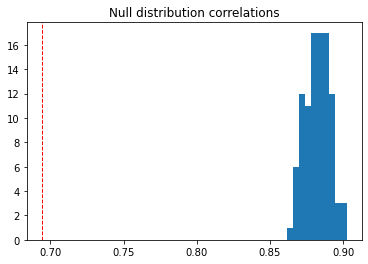

In [185]:
plt.hist(null_dist)
plt.axvline(test_stat, color='r', linestyle='dashed', linewidth=1)
plt.title('Null distribution correlations')
plt.show()

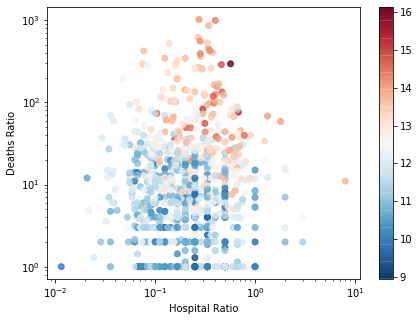

In [202]:
fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(
    deaths_df.hospital_diff,
    deaths_df.day_30,
    alpha = .8,
    c = np.log(deaths_df.POP_ESTIMATE_2018),
    cmap = 'RdBu_r'
)
ax.set_xlabel('Hospital Ratio')
ax.set_ylabel('Deaths Ratio')
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(sc)
plt.show()

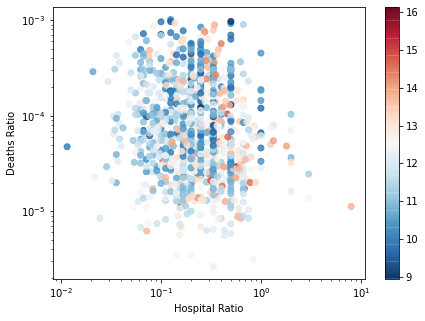

In [207]:
fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(
    deaths_df.hospital_diff,
    deaths_df.day_30 / deaths_df.POP_ESTIMATE_2018,
    alpha = .8,
    c = np.log(deaths_df.POP_ESTIMATE_2018),
    cmap = 'RdBu_r'
)
ax.set_xlabel('Hospital Ratio')
ax.set_ylabel('Deaths Ratio')
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(sc)
plt.show()

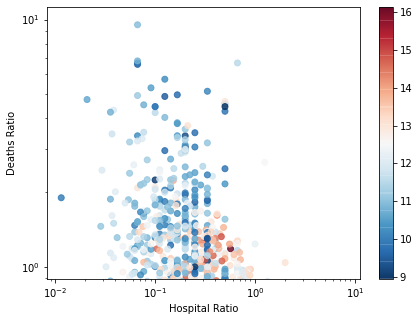

In [216]:
fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(
    deaths_df.hospital_diff,
    deaths_df.cum_death_diff_per_capita,
    alpha = .8,
    c = np.log(deaths_df.POP_ESTIMATE_2018),
    cmap = 'RdBu_r'
)
ax.set_xlabel('Hospital Ratio')
ax.set_ylabel('Deaths Ratio')
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(sc)
plt.show()

## Partial Correlations

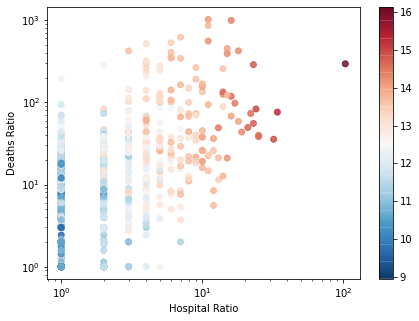

In [98]:
fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(
    deaths_df.HospCt,
    deaths_df.day_30,
    alpha = .8,
    c = np.log(deaths_df.POP_ESTIMATE_2018),
    cmap = 'RdBu_r'
)
ax.set_xlabel('Hospital Ratio')
ax.set_ylabel('Deaths Ratio')
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(sc)
plt.show()

In [148]:
from sklearn.linear_model import PoissonRegressor, LinearRegression, GammaRegressor

In [203]:
p_reg = LinearRegression(fit_intercept=False)#PoissonRegressor(alpha=0, fit_intercept=False) 
X = np.asarray(np.log(deaths_df['POP_ESTIMATE_2018'])).reshape((-1,1))
y = np.log(deaths_df[days[-1]])
yhat = p_reg.fit(X, y).predict(X)
death_resid = y - yhat

In [204]:
l_reg = LinearRegression(fit_intercept=False)#GammaRegressor(alpha=0, fit_intercept=False) 
X = np.asarray(np.log(deaths_df['POP_ESTIMATE_2018'])).reshape((-1,1))
y = np.log(deaths_df.hospital_diff)
yhat = l_reg.fit(X, y).predict(X)
hospct_resid = y - yhat

Text(0.5, 1.0, 'Hospital count residuals')

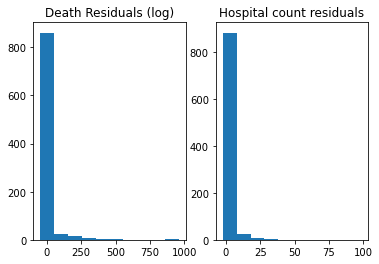

In [161]:
fig, axs = plt.subplots(1,2)
axs[0].hist(death_resid)
axs[0].set_title('Death Residuals (log)')
axs[1].hist(hospct_resid)
axs[1].set_title('Hospital count residuals')

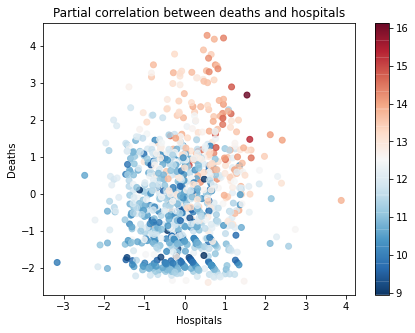

In [205]:
fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(
    hospct_resid,
    death_resid,
    alpha = .8,
    c = np.log(deaths_df.POP_ESTIMATE_2018),
    cmap = 'RdBu_r'
)
ax.set_xlabel('Hospitals')
ax.set_ylabel('Deaths')
plt.colorbar(sc)
plt.title('Partial correlation between deaths and hospitals')
plt.show()